# N-MNIST Classification

In this tutorial, we propose to train a network using per-layer local losses, as describe in [Kaiser et al. '20].
This tutorial is based on the SLAYER N-MNIST tutorial and we refer to it for data preprocessing.

NMNIST dataset is freely available [here](https://www.garrickorchard.com/datasets/n-mnist) (© CC-4.0).

> Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N. _"Converting Static Image Datasets to Spiking Neuromorphic Datasets Using Saccades"_,
Frontiers in Neuroscience, vol.9, no.437, Oct. 2015


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Create Dataset

The dataset class follows standard torch dataset definition. They are defined in `nmnist.py`. We will just import the dataset and augmentation routine here.

In [2]:
from tutorials.lava.lib.dl.slayer.nmnist.nmnist import NMNISTDataset, augment

/users/k1804053/lava-decolle


In [3]:
training_set = NMNISTDataset(train=True,
                             transform=augment, download=True)
testing_set  = NMNISTDataset(train=False,
                             )

train_loader = DataLoader(dataset=training_set, batch_size=256, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=256, shuffle=True)

# Create Networks

We consider here networks of Dense cuba blocks as shown below.
In addition to spiking blocks, DECOLLE models use fixed, readout layers to obtain per-layer errors.
The behavior of the cuba blocks is broken down during the forward pass to obtain the voltage, which is used in the custom `DECOLLELoss`.

In [4]:
class DECOLLENetwork(torch.nn.Module):
    def __init__(self, input_shape=34*34*2, hidden_shape=[512, 512], output_shape=10, burn_in=0):

        super(DECOLLENetwork, self).__init__()

        neuron_params = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        neuron_params_drop = {**neuron_params}

        self.burn_in = burn_in
        self.blocks = torch.nn.ModuleList()
        self.readout_layers = torch.nn.ModuleList()

        hidden_shape = [input_shape] + hidden_shape
        for i in range(len(hidden_shape)-1):
            self.blocks.append(slayer.block.cuba.Dense(
                neuron_params_drop, hidden_shape[i], hidden_shape[i+1],
                weight_norm=False)
            )

            # One fixed readout per layer
            readout = torch.nn.Linear(hidden_shape[i+1],
                                      output_shape,
                                      bias=False)
            readout.weight.requires_grad = False
            self.readout_layers.append(readout)


    def forward(self, spike):
        spike.requires_grad_()
        spikes = []
        readouts = []
        voltages = []
        count = []

        for block in self.blocks:
            # Decompose the behavior of the block to obtain the voltage
            # for the regularization
            z = block.synapse(spike.detach())
            _, voltage = block.neuron.dynamics(z)
            voltages.append(voltage)

            spike = block.neuron.spike(voltage)
            spikes.append(spike)
            count.append(torch.mean(spike.detach()))

        for ro, spike in zip(self.readout_layers, spikes):
            # Compute readouts
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(ro(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return spikes, readouts, voltages, count

    def init_state(self, inputs, burn_in=None):
        self.reset_()
        # initialize network state + crop inputs
        if burn_in is None:
            burn_in = self.burn_in

        self.forward(inputs[..., :burn_in])
        return inputs[..., burn_in:]

    def reset_(self):
        # reset the state after each example
        for block in self.blocks:
            block.neuron.current_state[:] = 0.
            block.neuron.voltage_state[:] = 0.


class SLAYERNetwork(torch.nn.Module):
    def __init__(self):
        super(SLAYERNetwork, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,
            }
        neuron_params = {**neuron_params}

        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params, 34*34*2, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 10, weight_norm=True),
            ])

    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

# Create save folder

In [5]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

# Instantiate DECOLLE Network, loss and Optimizer

In [6]:
from loss import DECOLLELoss
from utils import DECOLLEAssistant
import lava.lib.dl.slayer as slayer

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

decolle_net = DECOLLENetwork(burn_in=50).to(device)

error = DECOLLELoss(torch.nn.CrossEntropyLoss, reduction='mean')
optimizer = torch.optim.Adam(decolle_net.parameters(), lr=0.0001)

# Train DECOLLE Network

In [7]:
training_mode = 'online' # either 'online' or 'batch'

decolle_stats = slayer.utils.LearningStats()
decolle_assistant = DECOLLEAssistant(decolle_net, error, optimizer, decolle_stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

epochs = 20

for epoch in range(epochs):
    train_iter = iter(train_loader)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {decolle_stats}', end='')

    for i, (inputs, label) in tqdm(enumerate(train_iter)):  # training loop
        output, count = decolle_assistant.train(inputs, label)
    
    test_iter = iter(test_loader) 
    for i, (inputs, label) in enumerate(test_iter):  # testing loop
        output, count = decolle_assistant.test(inputs, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {decolle_stats}', end='')

    if epoch%5 == 4: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {decolle_stats}'))
        stats_str = str(decolle_stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')

    if decolle_stats.testing.best_accuracy:
        torch.save(decolle_net.state_dict(), trained_folder + '/decolle_network.pt')
    decolle_stats.update()

[Epoch  0/20] Train 

235it [08:36,  2.20s/it]


[Epoch  1/20] Train 

235it [08:31,  2.18s/it]


[Epoch  2/20] Train 

235it [08:36,  2.20s/it]


[Epoch  3/20] Train 

235it [08:47,  2.25s/it]


[Epoch  4/20] Train 

235it [08:40,  2.21s/it]


                                                                                                                                                                                       
[Epoch  4/20]
Train loss =   577.19156 (min =   589.13406)    accuracy = 0.90173 (max = 0.89637) 
Test  loss =   492.23828 (min =   500.18560)    accuracy = 0.91960 (max = 0.91980)
[Epoch  5/20] Train 

235it [08:38,  2.21s/it]


[Epoch  6/20] Train 

235it [08:41,  2.22s/it]


[Epoch  7/20] Train 

235it [08:32,  2.18s/it]


[Epoch  8/20] Train 

235it [08:24,  2.15s/it]


[Epoch  9/20] Train 

235it [08:27,  2.16s/it]


                                                                                                                                                                                       
[Epoch  9/20]
Train loss =   549.41556 (min =   553.54201)    accuracy = 0.91237 (max = 0.91193) 
Test  loss =   460.55082 (min =   465.56484)    accuracy = 0.94030 (max = 0.93560)
[Epoch 10/20] Train 

235it [08:37,  2.20s/it]


[Epoch 11/20] Train 

235it [08:34,  2.19s/it]


[Epoch 12/20] Train 

235it [08:39,  2.21s/it]


[Epoch 13/20] Train 

235it [08:48,  2.25s/it]


[Epoch 14/20] Train 

235it [08:49,  2.25s/it]


                                                                                                                                                                                       
[Epoch 14/20]
Train loss =   538.37806 (min =   540.17901)    accuracy = 0.91695 (max = 0.91557) 
Test  loss =   448.53329 (min =   450.59478)    accuracy = 0.94110 (max = 0.94200)
[Epoch 15/20] Train 

235it [09:00,  2.30s/it]


[Epoch 16/20] Train 

235it [09:01,  2.30s/it]


[Epoch 17/20] Train 

235it [08:34,  2.19s/it]


[Epoch 18/20] Train 

235it [08:39,  2.21s/it]


[Epoch 19/20] Train 

235it [08:31,  2.18s/it]


                                                                                                                                                                                       
[Epoch 19/20]
Train loss =   532.45950 (min =   533.41385)    accuracy = 0.91792 (max = 0.91825) 
Test  loss =   441.15609 (min =   443.35828)    accuracy = 0.94580 (max = 0.94470)


# Instantiate SLAYER Network, loss and Optimizer

In [8]:
from lava.lib.dl.slayer.loss import SpikeMax
from lava.lib.dl.slayer.utils import Assistant
import lava.lib.dl.slayer as slayer

trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

slayer_net = SLAYERNetwork().to(device)

error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)
optimizer = torch.optim.Adam(slayer_net.parameters(), lr=0.001)

slayer_stats = slayer.utils.LearningStats()
slayer_assistant = Assistant(slayer_net, error, optimizer, slayer_stats,
                             classifier=slayer.classifier.Rate.predict, count_log=False)

# Train SLAYER Network

In [9]:
epochs = 20

for epoch in range(epochs):
    train_iter = iter(train_loader)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {slayer_stats}', end='')
    
    for i, (inputs, label) in tqdm(enumerate(train_iter)):  # training loop
        output = slayer_assistant.train(inputs, label)
        
    test_iter = iter(test_loader)
    for i, (inputs, label) in enumerate(test_iter):  # testing loop
        output = slayer_assistant.test(inputs, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {slayer_stats}', end='')
        
    if epoch%5 == 4: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {slayer_stats}'))
        stats_str = str(slayer_stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if slayer_stats.testing.best_accuracy:
        torch.save(slayer_net.state_dict(), trained_folder + '/slayer_network.pt')
    slayer_stats.update()

[Epoch  0/20] Train 

235it [05:34,  1.42s/it]


[Epoch  1/20] Train 

235it [05:33,  1.42s/it]


[Epoch  2/20] Train 

235it [05:27,  1.39s/it]


[Epoch  3/20] Train 

235it [05:28,  1.40s/it]


[Epoch  4/20] Train 

235it [05:26,  1.39s/it]


                                                                                                                                                                                       
[Epoch  4/20]
Train loss =     1.58953 (min =     1.82621)    accuracy = 0.92802 (max = 0.91563) 
Test  loss =     1.18124 (min =     1.45982)    accuracy = 0.95310 (max = 0.94390)
[Epoch  5/20] Train 

235it [05:25,  1.39s/it]


[Epoch  6/20] Train 

235it [05:25,  1.39s/it]


[Epoch  7/20] Train 

235it [05:27,  1.40s/it]


[Epoch  8/20] Train 

235it [05:28,  1.40s/it]


[Epoch  9/20] Train 

235it [05:26,  1.39s/it]


                                                                                                                                                                                       
[Epoch  9/20]
Train loss =     1.19338 (min =     1.23929)    accuracy = 0.94867 (max = 0.94517) 
Test  loss =     0.99833 (min =     0.96501)    accuracy = 0.96490 (max = 0.96310)
[Epoch 10/20] Train 

235it [05:38,  1.44s/it]


[Epoch 11/20] Train 

235it [05:28,  1.40s/it]


[Epoch 12/20] Train 

235it [05:28,  1.40s/it]


[Epoch 13/20] Train 

235it [05:29,  1.40s/it]


[Epoch 14/20] Train 

235it [05:30,  1.40s/it]


                                                                                                                                                                                       
[Epoch 14/20]
Train loss =     1.10426 (min =     1.12349)    accuracy = 0.95322 (max = 0.95325) 
Test  loss =     0.86120 (min =     0.83228)    accuracy = 0.96650 (max = 0.96760)
[Epoch 15/20] Train 

235it [05:29,  1.40s/it]


[Epoch 16/20] Train 

235it [05:32,  1.42s/it]


[Epoch 17/20] Train 

235it [05:35,  1.43s/it]


[Epoch 18/20] Train 

235it [05:33,  1.42s/it]


[Epoch 19/20] Train 

235it [05:37,  1.44s/it]


                                                                                                                                                                                       
[Epoch 19/20]
Train loss =     1.00424 (min =     1.01767)    accuracy = 0.95955 (max = 0.95730) 
Test  loss =     0.76721 (min =     0.77002)    accuracy = 0.97250 (max = 0.97230)


# Plot the learning curves

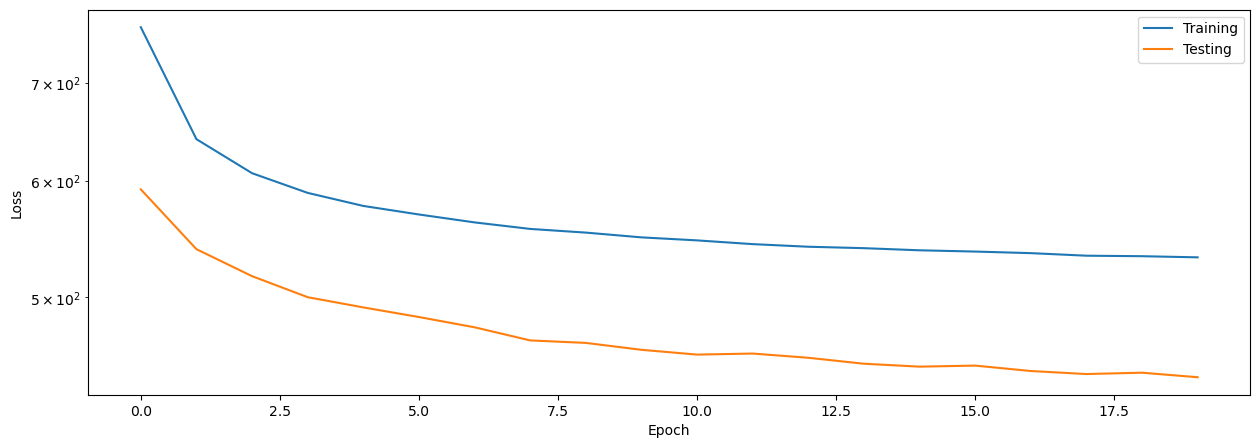

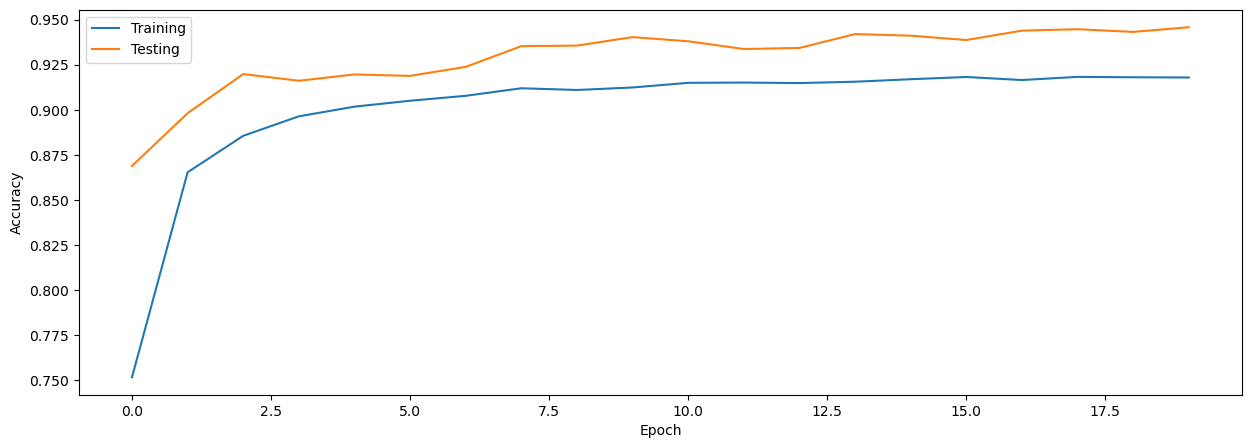

In [10]:
decolle_stats.plot(figsize=(15, 5))

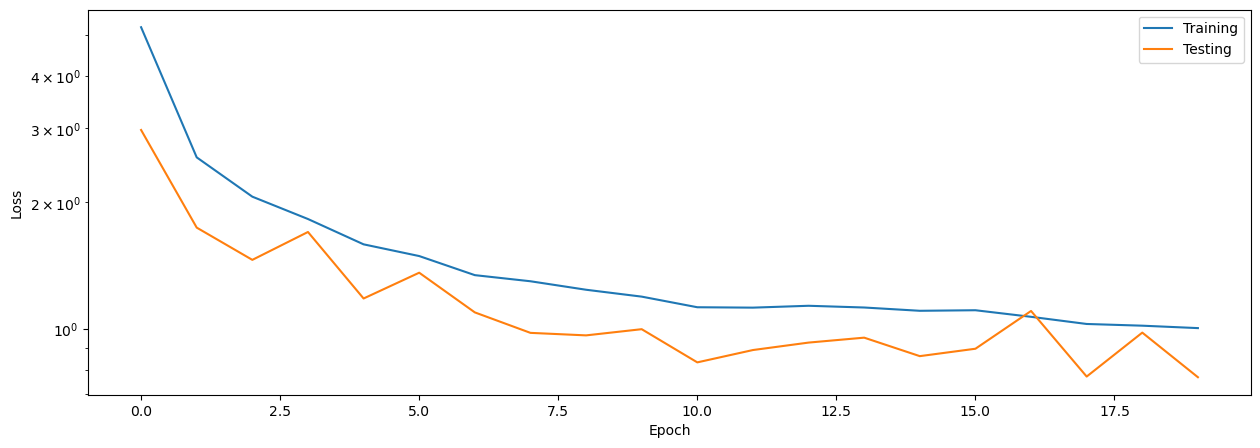

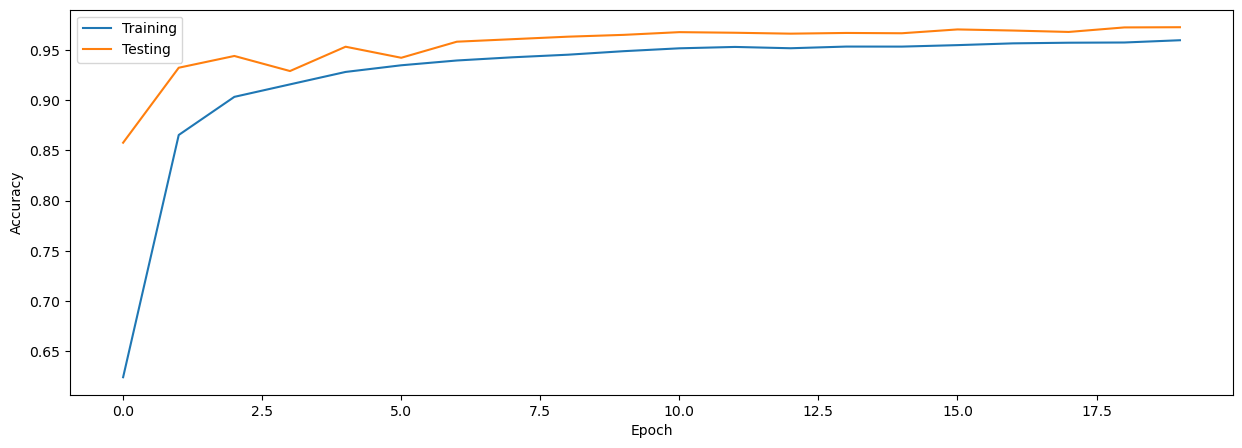

In [11]:
slayer_stats.plot(figsize=(15, 5))